In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf
from copy import deepcopy

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)


Using TensorFlow backend.


In [2]:
# some constants
NUM_CLASSES = 3
input_shape = (300, 300, 3)
input_shape[1]

300

In [3]:
import pandas as pd

df_files1=pd.read_csv('/Users/simin/Desktop/didi-udacity-2017-master/test1.csv', header=0)

# df_vehicles=df_files[(df_files['Label']=='Car')|(df_files['Label']=='Truck')|(df_files['Label']=='Pedestrian')\
#                   |(df_files['Label']=='Cyclist')|(df_files['Label']=='Van')].reset_index()
df_vehicles1=df_files1[(df_files1['Label']=='Car')|(df_files1['Label']=='Truck')|(df_files1['Label']=='Van')].reset_index()
df_vehicles1=df_vehicles1.drop('index',1)

# df_vehicles['File_Path']='top_image'+'/'+df_vehicles['Frame']

df_vehicles1.head()

,File_Path,Frame,Label,xmin,xmax,ymin,ymax
0,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00000.png,Car,76.0,91.0,167.0,200.0
1,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00000.png,Car,79.0,98.0,117.0,160.0
2,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00000.png,Car,85.0,103.0,70.0,107.0
3,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00001.png,Car,75.0,90.0,180.0,213.0
4,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00001.png,Car,79.0,97.0,129.0,173.0


In [4]:
df_files2=pd.read_csv('/Users/simin/Desktop/didi-udacity-2017-master/test2.csv', header=0)
df_vehicles2=df_files2[(df_files2['Label']=='Car')|(df_files2['Label']=='Van')].reset_index()
df_vehicles2=df_vehicles2.drop('index',1)

df_vehicles2.head()

,File_Path,Frame,Label,xmin,xmax,ymin,ymax
0,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image2_00000.png,Car,192.0,220.0,221.0,260.0
1,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image2_00000.png,Car,125.0,141.0,99.0,136.0
2,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image2_00000.png,Car,184.0,202.0,-103.0,-62.0
3,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image2_00000.png,Van,109.0,131.0,-275.0,-209.0
4,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image2_00000.png,Car,329.0,372.0,217.0,258.0


In [5]:
df_files3=pd.read_csv('/Users/simin/Desktop/didi-udacity-2017-master/test3.csv', header=0)
df_vehicles3=df_files3[(df_files3['Label']=='Car')|(df_files3['Label']=='Van')|(df_files3['Label']=='Truck')].reset_index()
df_vehicles3=df_vehicles3.drop('index',1)
df_vehicles3.head()

,File_Path,Frame,Label,xmin,xmax,ymin,ymax
0,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image3_00000.png,Car,243.0,259.0,311.0,344.0
1,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image3_00000.png,Car,184.0,231.0,66.0,90.0
2,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image3_00000.png,Car,84.0,103.0,-154.0,-114.0
3,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image3_00000.png,Car,93.0,130.0,44.0,70.0
4,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image3_00000.png,Car,55.0,73.0,-143.0,-113.0


In [6]:
df_vehicles=pd.concat([df_vehicles1,df_vehicles2,df_vehicles3]).reset_index()
df_vehicles=df_vehicles.drop('index',1)
df_vehicles.columns=['File_Path','Frame','Label','xmin','xmax','ymin','ymax']
df_vehicles['varxc']=0.1
df_vehicles['varyc']=0.1
df_vehicles['varw']=0.2
df_vehicles['varh']=0.2
a=df_vehicles[df_vehicles['xmin']>=0]
b=a[a['xmax']<=500]
c=b[b['ymin']>=0]
e=c[c['ymax']<=400]
df_vehicles=e.reset_index()
# df_vehicles['Frame'][3002]

In [7]:
df_vehicles.head(30)

,index,File_Path,Frame,Label,xmin,xmax,ymin,ymax,varxc,varyc,varw,varh
0,0,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00000.png,Car,76.0,91.0,167.0,200.0,0.1,0.1,0.2,0.2
1,1,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00000.png,Car,79.0,98.0,117.0,160.0,0.1,0.1,0.2,0.2
2,2,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00000.png,Car,85.0,103.0,70.0,107.0,0.1,0.1,0.2,0.2
3,3,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00001.png,Car,75.0,90.0,180.0,213.0,0.1,0.1,0.2,0.2
4,4,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00001.png,Car,79.0,97.0,129.0,173.0,0.1,0.1,0.2,0.2
5,5,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00001.png,Car,84.0,102.0,81.0,119.0,0.1,0.1,0.2,0.2
6,6,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00002.png,Car,74.0,88.0,193.0,225.0,0.1,0.1,0.2,0.2
7,7,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00002.png,Car,78.0,96.0,142.0,186.0,0.1,0.1,0.2,0.2
8,8,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00002.png,Car,83.0,100.0,93.0,130.0,0.1,0.1,0.2,0.2
9,9,/Users/simin/Desktop/didi-udacity-2017-master/...,top_image_00003.png,Car,77.0,95.0,155.0,199.0,0.1,0.1,0.2,0.2


In [8]:
len(df_vehicles)


3237

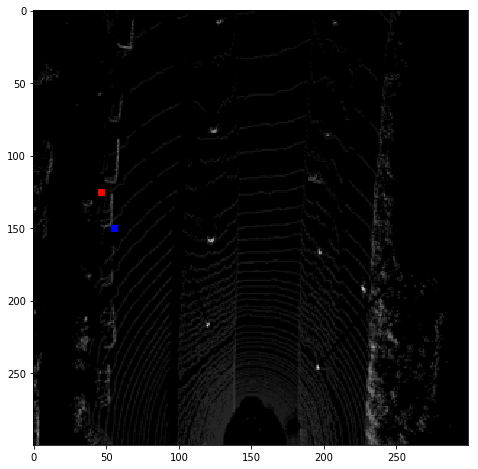

In [9]:
imm=cv2.imread(df_vehicles['File_Path'][0])
imm=imresize(imm,(300,300))
# 46. ,  125. ,   55. ,  150
plt.plot(46,125,'rs')
plt.plot(55,150,'bs')
# plt.axis('off');
plt.imshow(imm)
image_shape=(400,500,3) #h,w,ch

In [10]:
# file_name=df_vehicles['File_Path'][800]
# name_str=file_name.split('/')
# name_str=name_str[-1]
# boxes=df_vehicles[df_vehicles['Frame']==name_str].reset_index()

# # a=boxes['ymin']>=0
# bb=boxes[((boxes['ymin']>=0) and (boxes['ymin']<=400 )]
# # bb[boxes['ymin']<=400]

In [11]:
keys=[]
bboxes=[]
for i in range(len(df_vehicles)):
    file_name=df_vehicles['File_Path'][i]
    name_str=file_name.split('/')
    name_str=name_str[-1]
    boxes=df_vehicles[df_vehicles['Frame']==name_str].reset_index()
    boxes['xmin']=np.round((boxes['xmin'])/image_shape[1]*input_shape[1])
    boxes['ymin']=np.round((boxes['ymin'])/image_shape[0]*input_shape[0])
    boxes['xmax']=np.round((boxes['xmax'])/image_shape[1]*input_shape[1])
    boxes['ymax']=np.round((boxes['ymax'])/image_shape[0]*input_shape[0])
#     boxes['xmin']=boxes[boxes['xmin']>=0]
#     boxes['xmin']=boxes[boxes['xmin']<=300]
#     for j in range(len(boxes)):
        
#     if 0<=boxes[i]['xmin']<=300 and 0<=boxes[i]['ymin']<=300 and 0<=boxes[i]['xmax']<=300 and 0<=boxes[i]['ymax']<=300:
    bboxes.append(boxes)
    
len(bboxes)
# priors=np.asarray(priors)
# # keys=np.asarray(keys)
# priors.shape

3237

In [12]:


priors=[]
keys=[]

for k in range(len(bboxes)):
    bb=np.zeros((len(bboxes[k]),8))
    bb2=np.zeros((len(bboxes[k]),4))
#     frame=bboxes[k]['File_Path']
    for j in range(len(bboxes[k])):
        xmin=bboxes[k]['xmin'][j]
        ymin=bboxes[k]['ymin'][j]
        xmax=bboxes[k]['xmax'][j]
        ymax=bboxes[k]['ymax'][j]
        
        varx=0.1
        vary=0.1
        varw=0.2
        varh=0.2
#         if 0<=xmin and xmin<=300 and 0<=ymin and ymin<=300 and 0<=xmax and xmax<=300 and 0<=ymax and ymax<=300:
        box=[xmin,ymin,xmax,ymax,varx,vary,varw,varh]
        box2=[xmin, ymin, xmax,ymax]
        bb[j]=box
        bb2[j]=box2
    priors.append(bb)
    keys.append(bb2)
priors=np.asarray(priors)
keys=np.asarray(keys)
print(len(priors))
len(keys)

3237


3237

In [13]:
priors[0].shape
keys[0]
# plt.plot(keys[0][:,0], keys[0][:,1],'rs')
# plt.plot(keys[0][:,2],keys[0][:,3],'bs')
# plt.axis('off');
# plt.imshow(imm)
# keys[0]

array([[  46.,  125.,   55.,  150.],
       [  47.,   88.,   59.,  120.],
       [  51.,   52.,   62.,   80.]])

In [14]:
k=keys[500]

k
# shuffle(k)
# tar=keys[0:10,1:]
# for i in k:
#     print(i[0])
#     g=k[k[:,0]==i[0]]
#     print(i[1:])
# #     print(i.astype('float32'))
# #     print(i[0])

array([[  75.,   74.,   85.,  102.],
       [  93.,    2.,  103.,   29.],
       [  75.,   16.,   84.,   46.],
       [ 197.,  163.,  223.,  194.]])

In [23]:

saturation_var=0.5
brightness_var=0.5
contrast_var=0.5
lighting_std=0.5
hflip_prob=0.5
vflip_prob=0.5


def grayscale(rgb):
    return rgb.dot([0.299, 0.587, 0.114])

def saturation(rgb):
    gs = grayscale(rgb)
    alpha = 2 * np.random.random() * saturation_var 
    alpha += 1 - saturation_var
    rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
    return np.clip(rgb, 0, 255)

def brightness(rgb):
    rgb=cv2.cvtColor(rgb, cv2.COLOR_RGB2YUV)
    random_bright=1.5+np.random.uniform()
    rgb[:,:,0]=rgb[:,:,0]*random_bright
    rgb=cv2.cvtColor(rgb, cv2.COLOR_YUV2RGB)
#     alpha = 2 * np.random.random() * brightness_var 
#     alpha += 1 - saturation_var
#     rgb = rgb * alpha
    return rgb

def contrast( rgb):
    gs = grayscale(rgb).mean() * np.ones_like(rgb)
    alpha = 2 * np.random.random() * contrast_var 
    alpha += 1 - contrast_var
    rgb = rgb * alpha + (1 - alpha) * gs
    return np.clip(rgb, 0, 255)

def trans_image(image,y,trans_range):
    # Translation augmentation
    y1 = deepcopy(y)

    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    rows,cols,channels = image.shape
    y1[:,0] = y[:,0]+tr_x
    y1[:,2] = y[:,2]+tr_x
    y1[:,1] = y[:,1]+tr_y
    y1[:,3] = y[:,3]+tr_y
    
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,y1

def stretch_image(img,y,scale_range):
    # Stretching augmentation 
    
    y2 = deepcopy(y)
    
    
    tr_x1 = scale_range*np.random.uniform()
    tr_y1 = scale_range*np.random.uniform()
    p1 = (tr_x1,tr_y1)
    tr_x2 = scale_range*np.random.uniform()
    tr_y2 = scale_range*np.random.uniform()
    p2 = (img.shape[1]-tr_x2,tr_y1)

    p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
    p4 = (tr_x1,img.shape[0]-tr_y2)

    pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
    pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],
                   [0,img.shape[0]] ]
                   )

    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
    img = np.array(img,dtype=np.float64)
    
    y2[:,0] = (y[:,0] - p1[0])/(p2[0]-p1[0])*img.shape[1]
    y2[:,2] = (y[:,2] - p1[0])/(p2[0]-p1[0])*img.shape[1]
    y2[:,1] = (y[:,1] - p1[1])/(p3[1]-p1[1])*img.shape[0]
    y2[:,3] = (y[:,3] - p1[1])/(p3[1]-p1[1])*img.shape[0]
    
#     plt.plot(p1[0],p1[1],'mo')
#     plt.plot(p2[0],p2[1],'mo')
#     plt.plot(p3[0],p3[1],'mo')
#     plt.plot(p4[0],p4[1],'mo')
    
    return img,y2

def horizontal_flip( img, y):
    y1 = deepcopy(y)
    if np.random.random() < hflip_prob:
        img = img[:, ::-1]
        y1[:, [0, 2]] = img.shape[1] - y[:, [2, 0]]
    return img, y1

def vertical_flip(img, y):
    y2 = deepcopy(y)
    if np.random.random() < vflip_prob:
        img = img[::-1]
        y2[:, [1, 3]] = 300 - y[:, [3, 1]]
        
    return img, y2

def rotate_image(image, y):
     
    
    y1 = deepcopy(y)
    num=np.random.randint(5)
    angle=90*num
    h,w,ch=image.shape

    
    
    M=cv2.getRotationMatrix2D((w//2,h//2),angle,1)
    cos1=np.abs(M[0,0])
    sin1=np.abs(M[0,1])
    cos=np.cos(angle*np.pi/180)
    sin=np.sin(angle*np.pi/180)
    nw=int((h*sin1)+(w*cos1))
    nh=int((h*cos1)+(w*sin1))
   
    M[0,2]+=(nw/2)-w//2
    M[1,2]+=(nh/2)-h//2
    
#     cw=np.abs((nw/2)-w/2)
#     ch=np.abs((nh/2)-h/2)

    rot_im=cv2.warpAffine(image,M,(nw,nh))
    
    crx=(rot_im.shape[1]//2)
    cry=(rot_im.shape[0]//2)
    delta_x=0
    delta_y=0
#     delta_x=int((crx-w//2))*sin
#     delta_y=int((cry-h//2))*sin
    print(delta_x)
    y1[:,0] = np.rint((y[:,0]-crx)*cos + (y[:,1]-cry)*sin + crx)+delta_y
    y1[:,1] = np.rint(cry - (y[:,0]-crx)*sin + (y[:,1]-cry)*cos)-delta_x
    y1[:,2] = np.rint((y[:,2]-crx)*cos + (y[:,3]-cry)*sin + crx)+delta_y
    y1[:,3] = np.rint(cry - (y[:,2]-crx)*sin + (y[:,3]-cry)*cos)-delta_x
    
#     print(delta_x, delta_y)
#     print('nw',str(nw), 'nh',str(nh))
#     plt.plot(rot_im.shape[1]/2,rot_im.shape[0]/2,'rs')
    return rot_im, y1

0


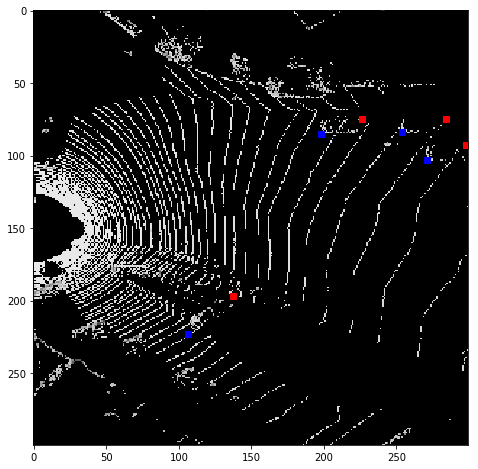

In [24]:
path=df_vehicles['File_Path'][500]
img=image.load_img(path, target_size=(300, 300))
img=image.img_to_array(img)
# img=img.astype(dtype='uint8')

img1,tar=rotate_image(img,k)
plt.imshow(img1)
# plt.imshow(im2)
plt.plot(tar[:,0],tar[:,1],'rs')
plt.plot(tar[:,2],tar[:,3],'bs')



In [ ]:
len(priors)
priors[0]

In [ ]:
# img = imread(keys[0][0]).astype('uint8')
# plt.imshow(img)

In [ ]:
NUM_CLASSES=3
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [ ]:
print(len(priors))
len(keys)

In [ ]:
bboxes[0]['Frame']

In [ ]:
num_train = int(round(0.8 * len(keys)))
train_labels = keys[:num_train]
train_paths=df_vehicles['File_Path'][:num_train]
val_labels = keys[num_train:]
val_paths=df_vehicles['File_Path'][num_train:]
num_val = len(val_labels)


print(len(train_labels))
print(len(train_paths))
print(len(val_labels))
print(len(val_paths))


In [ ]:
# train[2589]['Frame']

In [ ]:
# shuffle(train)
# # shuffle(train_labels)


In [ ]:
print(train_paths[2500])
print(train_labels[2500])
gm=image.load_img(train_paths[2500], target_size=(300, 300))
gm=image.img_to_array(gm)
gm=gm.astype(dtype='uint8')
plt.imshow(gm)
plt.plot(train_labels[2500][:,0],train_labels[2500][:,1],'rs')
plt.plot(train_labels[2500][:,2],train_labels[2500][:,3],'bs')

In [ ]:
len(train_labels[2500])
t=train_labels[2500].reshape(-1,1,4)
t.shape

In [ ]:
color_jitter=np.array([[0],[1],[2],[3]])
shuffle(color_jitter)
color_jitter

In [ ]:
def Generator(train_paths,train_labels, val_paths,val_labels, bbox_util, batch_size, train=True):
    trans_range=30
    scale_range=30
    img_rows=300
    img_cols=300

#     batch_boxes = np.zeros((batch_size, img_rows, img_cols, 1))
    while True:
        batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
        targets = []

        if train:
            paths=train_paths
            keys = train_labels
        else:
            paths=val_paths
            keys = val_labels

        for i_batch in range(batch_size):
            i_line = np.random.randint(len(paths))
            img_path =paths[i_line]
            y=deepcopy(keys[i_line])
            num=len(y)
            img=image.load_img(img_path, target_size=(300, 300))
            img=image.img_to_array(img)
            img=img.astype(dtype='uint8')
            targets = []
            rand=np.random.randint(3)
            if train:
                if rand==0:
                    img,y=trans_image(img,y,trans_range)
                elif rand==1:
                    img,y=stretch_image(img,y,scale_range)
                elif rand==2:
                    img, y=rotate_image(img, y)          

                img=saturation(img)
                img=img.astype(dtype='uint8')
                img=contrast(img)
                img=img.astype(dtype='uint8')
                img=brightness(img)
                img=img.astype(dtype='uint8')
            if num>=0:
            y = bbox_util.assign_boxes(y[num-1])
#                 num-=1
                targets.append(y)
                
            batch_images[i_batch] = img         
            tmp_targets = np.array(targets)
        yield preprocess_input(batch_images), tmp_targets

In [ ]:
gen = Generator(train_paths,train_labels, val_paths,val_labels, bbox_util, batch_size=1)

In [ ]:
batch_img, batch_mask= next(gen)
batch_mask

In [ ]:
for i in range(3):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();

In [ ]:
# priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
# bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [ ]:
len(priors)

In [ ]:
gt = pickle.load(open('gt_pascal.pkl', 'rb'))
keys = sorted(gt.keys())
# len(keys)
# keys[-1]
# num_train = int(round(0.8 * len(keys)))
# train_keys = keys[:num_train]
# val_keys = keys[num_train:]
# num_val = len(val_keys)
for k in keys[0:10]:
    a=gt[k].copy()
    print(a)

In [ ]:

for key in keys:  
    
    img_path = self.path_prefix + key
    img = imread(img_path).astype('float32')
    y = self.gt[key].copy()